In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
import os

In [2]:
from brian2 import *
from brian2tools import *

import matplotlib.pyplot as plt

import cx_rate
import trials
import plotter


from cx_spiking.constants import *

import cx_spiking.plotting
import cx_spiking.inputs
import cx_spiking.network_creation as nc

import cx_spiking.optimisation.metric as metric
import cx_spiking.optimisation.ng_optimiser as ng_optimiser

# Inputs

In [3]:
route_file = os.path.join(os.environ.get('MSC_PROJECT'), 'notebooks/data/route.npz')
T_outbound = 1500

h, v, = cx_spiking.inputs.generate_route(T_outbound=1500, vary_speed=True, route_file=route_file, load_route=True)

cx_spiking.inputs.save_route(route_file, h, v, save_route=True)

# Convert headings
headings = cx_spiking.inputs.compute_headings(h, N=N_TL2//2, vmin=5, vmax=100)
headings = np.tile(headings, 2)

# Convert velocity into optical flow
flow = cx_spiking.inputs.compute_flow(h, v, baseline=50, vmin=0, vmax=50)

Load route from /Users/ff/dev/MSc/CX_Path_Integration/notebooks/data/route.npz
/Users/ff/dev/MSc/CX_Path_Integration/notebooks/data/route.npz exists - not overwriting it


In [4]:
noise = 0.1
cx = cx_rate.CXRatePontin(noise=noise)

h, v, cx_log, cpu4_snapshot = trials.run_trial(logging=True,
                                               T_outbound=T_outbound,
                                               T_inbound=0,
                                               noise=noise,
                                               cx=cx,
                                               route=(h[:T_outbound], v[:T_outbound]))

# Network

In [15]:
start_scope()

time_step = 60 # ms

h_stimulus = TimedArray(headings*Hz, dt=1.*time_step*ms)
P_HEADING = PoissonGroup(N_TL2, rates='h_stimulus(t,i)')

f_stimulus = TimedArray(flow*Hz, dt=1.*time_step*ms)
P_FLOW = PoissonGroup(N_TN2, rates='f_stimulus(t,i)')

In [16]:
G_TL2 = nc.generate_neuron_groups(N_TL2, eqs, threshold_eqs, reset_eqs, TL2_neuron_params)
G_CL1 = nc.generate_neuron_groups(N_CL1, eqs, threshold_eqs, reset_eqs, CL1_neuron_params)
G_TB1 = nc.generate_neuron_groups(N_TB1, eqs, threshold_eqs, reset_eqs, TB1_neuron_params)
G_TN2 = nc.generate_neuron_groups(N_TN2, eqs, threshold_eqs, reset_eqs, TN2_neuron_params)

In [17]:
fitted_params = neuron_params
fitted_synapses = synapses_params

fitted_params['tauE'] = 0.5*ms
fitted_params['tauI'] = 0.5*ms

fitted_synapses['wE'] = 800*nS
fitted_synapses['wI'] = 700*nS

In [18]:
G_CPU4 = nc.generate_neuron_groups(N_CPU4, eqs, threshold_eqs, reset_eqs, fitted_params)
G_CPU1A = nc.generate_neuron_groups(N_CPU1A, eqs, threshold_eqs, reset_eqs, fitted_params)
G_CPU1B = nc.generate_neuron_groups(N_CPU1B, eqs, threshold_eqs, reset_eqs, fitted_params)
G_PONTINE = nc.generate_neuron_groups(N_PONTINE, eqs, threshold_eqs, reset_eqs, fitted_params)
G_MOTOR = nc.generate_neuron_groups(N_MOTOR, eqs, threshold_eqs, reset_eqs, fitted_params)

In [19]:
SPM_TL2 = SpikeMonitor(G_TL2)
SPM_CL1 = SpikeMonitor(G_CL1)
SPM_TB1 = SpikeMonitor(G_TB1)
SPM_TN2 = SpikeMonitor(G_TN2)
SPM_CPU4 = SpikeMonitor(G_CPU4)
SPM_CPU1A = SpikeMonitor(G_CPU1A)
SPM_CPU1B = SpikeMonitor(G_CPU1B)
SPM_PONTINE = SpikeMonitor(G_PONTINE)
SPM_MOTOR = SpikeMonitor(G_MOTOR)

In [20]:
S_P_HEADING_TL2 = nc.connect_synapses(P_HEADING, G_TL2, W_HEADING_TL2, model=synapses_model, 
                                      params=H_TL2_synapses_params, on_pre=synapses_eqs_ex)
S_TL2_CL1 = nc.connect_synapses(G_TL2, G_CL1, W_TL2_CL1, model=synapses_model, 
                                params=TL2_CL1_synapses_params, on_pre=synapses_eqs_ex)
S_CL1_TB1 = nc.connect_synapses(G_CL1, G_TB1, W_CL1_TB1, model=synapses_model, 
                                params=CL1_TB1_synapses_params, on_pre=synapses_eqs_ex)
S_TB1_TB1 = nc.connect_synapses(G_TB1, G_TB1, W_TB1_TB1, model=synapses_model, 
                                params=TB1_TB1_synapses_params, on_pre=synapses_eqs_in)
S_P_FLOW_TN2 = nc.connect_synapses(P_FLOW, G_TN2, W_FLOW_TN2, model=synapses_model, 
                                   params=F_TN2_synapses_params, on_pre=synapses_eqs_ex)

In [21]:
S_TB1_CPU4 = nc.connect_synapses(G_TB1, G_CPU4, W_TB1_CPU4, model=synapses_model, 
                                 params=fitted_synapses, on_pre=synapses_eqs_in)
S_TN2_CPU4 = nc.connect_synapses(G_TN2, G_CPU4, W_TN2_CPU4, model=synapses_model, 
                                 params=fitted_synapses, on_pre=synapses_eqs_ex)
S_TB1_CPU1A = nc.connect_synapses(G_TB1, G_CPU1A, W_TB1_CPU1A, model=synapses_model, 
                                  params=fitted_synapses, on_pre=synapses_eqs_in)
S_CPU4_PONTINE = nc.connect_synapses(G_CPU4, G_PONTINE, W_CPU4_PONTINE, model=synapses_model, 
                                     params=fitted_synapses,  on_pre=synapses_eqs_ex)
S_CPU4_CPU1A = nc.connect_synapses(G_CPU4, G_CPU1A, W_CPU4_CPU1A, model=synapses_model, 
                                   params=fitted_synapses,  on_pre=synapses_eqs_ex)
S_PONTINE_CPU1A = nc.connect_synapses(G_PONTINE, G_CPU1A, W_PONTINE_CPU1A, model=synapses_model, 
                                      params=fitted_synapses,  on_pre=synapses_eqs_in)
S_TB1_CPU1B = nc.connect_synapses(G_TB1, G_CPU1B, W_TB1_CPU1B, model=synapses_model, 
                                  params=fitted_synapses,  on_pre=synapses_eqs_in)
S_CPU4_CPU1B = nc.connect_synapses(G_CPU4, G_CPU1B, W_CPU4_CPU1B, model=synapses_model, 
                                   params=fitted_synapses,  on_pre=synapses_eqs_ex)
S_PONTINE_CPU1B = nc.connect_synapses(G_PONTINE, G_CPU1B, W_PONTINE_CPU1B, model=synapses_model, 
                                      params=fitted_synapses,  on_pre=synapses_eqs_in)
S_CPU1A_MOTOR = nc.connect_synapses(G_CPU1A, G_MOTOR, W_CPU1A_MOTOR, model=synapses_model, 
                                    params=fitted_synapses,  on_pre=synapses_eqs_ex)
S_CPU1B_MOTOR = nc.connect_synapses(G_CPU1B, G_MOTOR, W_CPU1B_MOTOR, model=synapses_model, 
                                    params=fitted_synapses,  on_pre=synapses_eqs_ex)

In [22]:
%%time
run(T_outbound*time_step*ms, report='text')

Starting simulation at t=0. s for a duration of 90. s
1.2973 s (1%) simulated in 10s, estimated 11m 24s remaining.
1.9992 s (2%) simulated in 20s, estimated 14m 40s remaining.
2.9595 s (3%) simulated in 30s, estimated 14m 42s remaining.
4.1374 s (4%) simulated in 40s, estimated 13m 50s remaining.
5.3035 s (5%) simulated in 50s, estimated 13m 19s remaining.
6.5984 s (7%) simulated in 1m 0s, estimated 12m 38s remaining.
7.7131 s (8%) simulated in 1m 10s, estimated 12m 27s remaining.
8.7984 s (9%) simulated in 1m 20s, estimated 12m 18s remaining.
9.6763 s (10%) simulated in 1m 30s, estimated 12m 27s remaining.
10.7766 s (11%) simulated in 1m 40s, estimated 12m 15s remaining.
11.9834 s (13%) simulated in 1m 50s, estimated 11m 56s remaining.
13.2115 s (14%) simulated in 2m 0s, estimated 11m 38s remaining.
14.3922 s (15%) simulated in 2m 10s, estimated 11m 23s remaining.
15.1487 s (16%) simulated in 2m 20s, estimated 11m 32s remaining.
16.209 s (18%) simulated in 2m 30s, estimated 11m 23s re

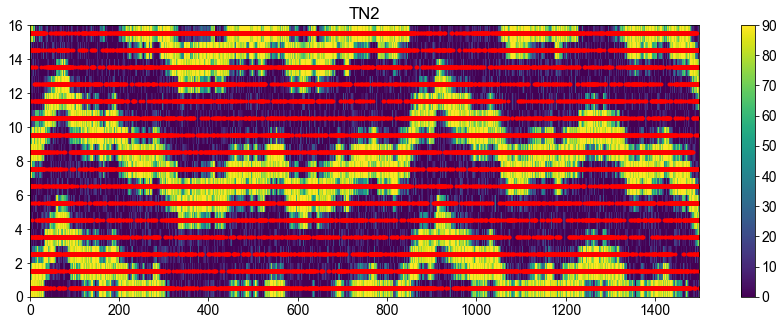

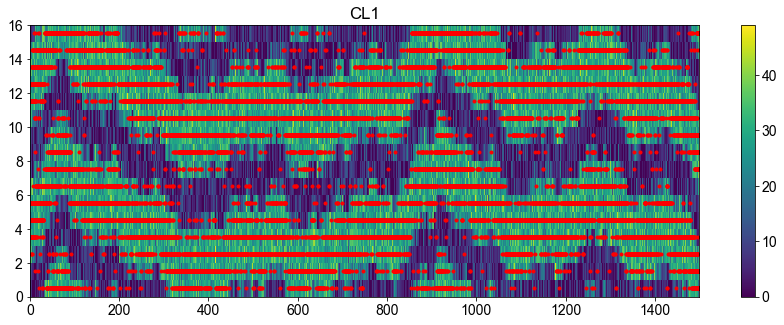

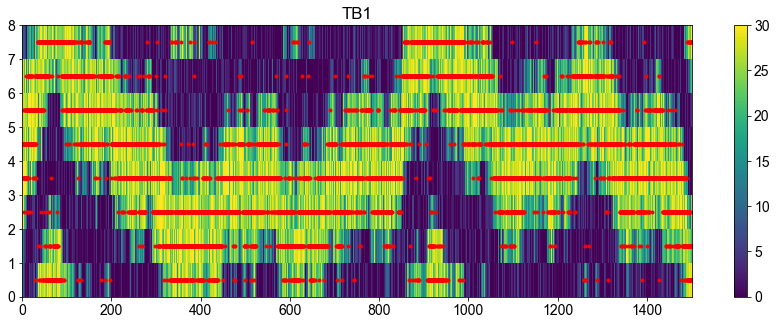

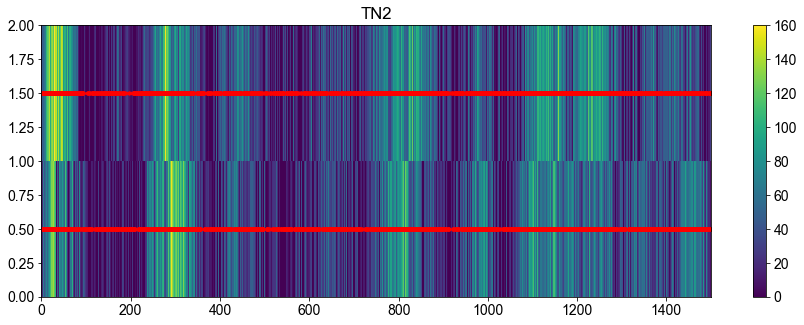

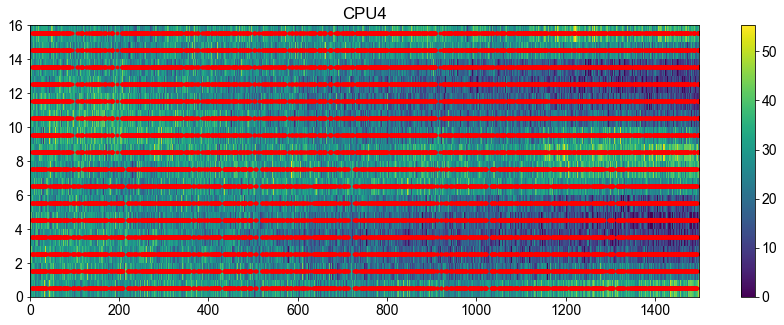

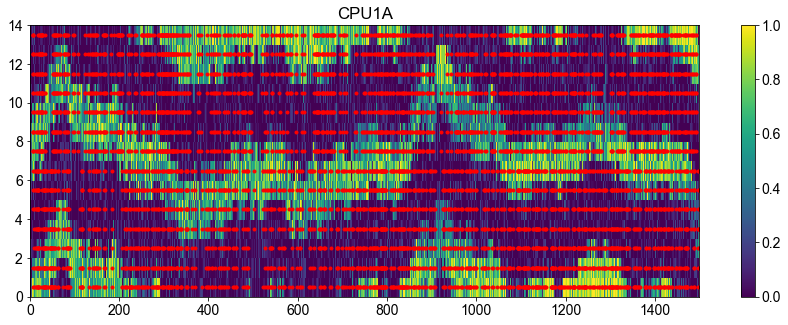

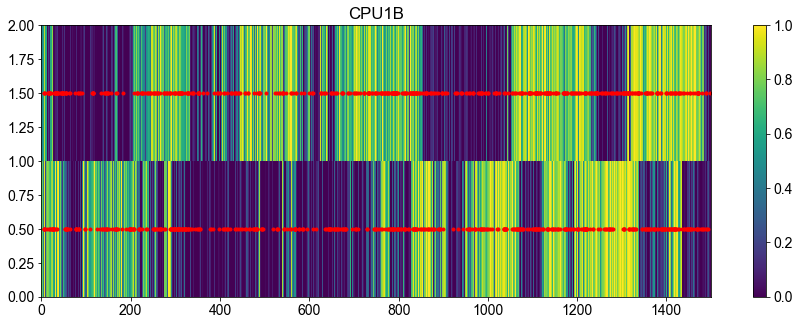

In [23]:
folder = 'fitted_model_06'
cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.tl2, TL2_spike_rates, SPM_TL2, time_step, 
                                            title='TN2', figsize=(15,5), savefig_=f'{folder}/TN2.pdf')
cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.cl1, CL1_spike_rates, SPM_CL1, time_step,
                                            title='CL1',  figsize=(15,5), savefig_=f'{folder}/CL1.pdf')
cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.tb1, TB1_spike_rates, SPM_TB1, time_step, 
                                            title='TB1',  figsize=(15,5), savefig_=f'{folder}/TB1.pdf')
cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.tn2, TN2_spike_rates_max, SPM_TN2, time_step,
                                            title='TN2',  figsize=(15,5), savefig_=f'{folder}/TN2.pdf')
cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.cpu4, 60, SPM_CPU4, time_step, 
                                            title='CPU4',  figsize=(15,5), savefig_=f'{folder}/CPU4.pdf')
cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.cpu1[1:-1,:], 1, SPM_CPU1A, time_step,
                                            title='CPU1A',  figsize=(15,5), savefig_=f'{folder}/CPU1A.pdf')
cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.cpu1[[1,-1],:], 1, SPM_CPU1B, time_step, 
                                            title='CPU1B',  figsize=(15,5), savefig_=f'{folder}/CPU1B.pdf')

(2, 1500)


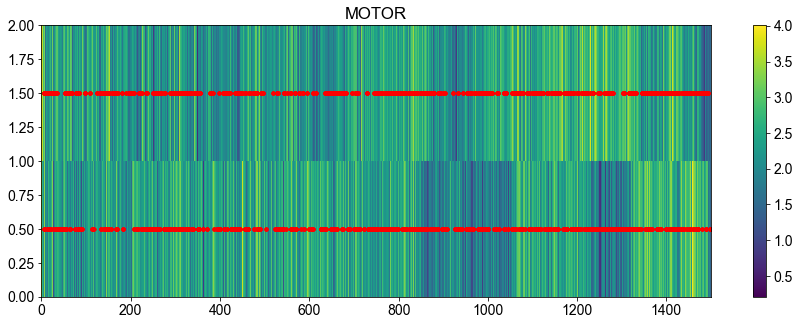

In [24]:
motors = cx_spiking.inputs.compute_motors(cx_log.cpu1)
print(motors.shape)
cx_spiking.plotting.plot_motors_cx_log_spikes(motors, motors.max(), SPM_MOTOR, time_step, min_rate=motors.min(), 
                                            title='MOTOR',  figsize=(15,5), savefig_=f'{folder}/MOTOR.pdf')

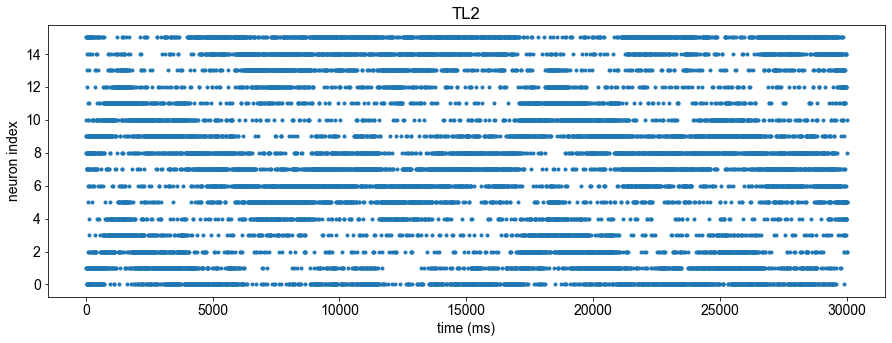

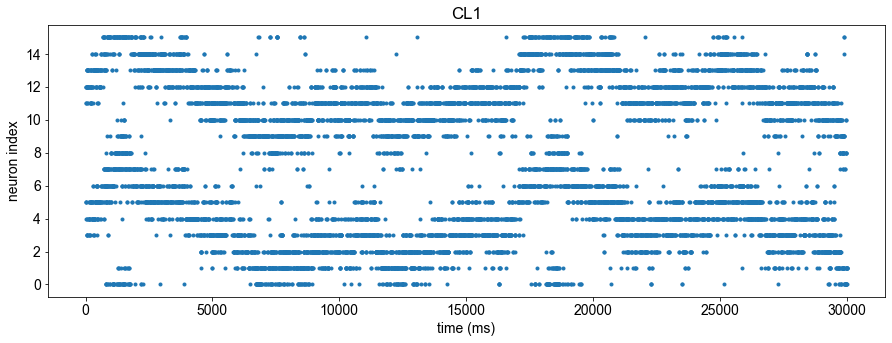

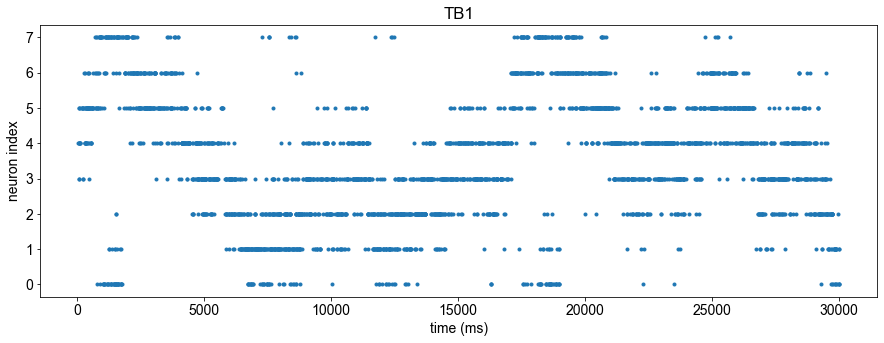

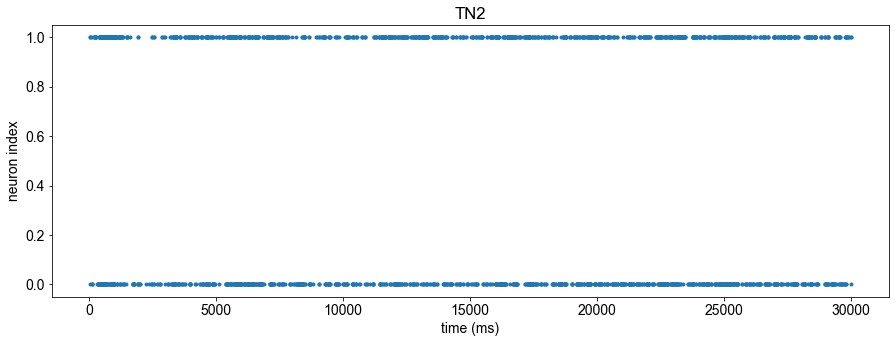

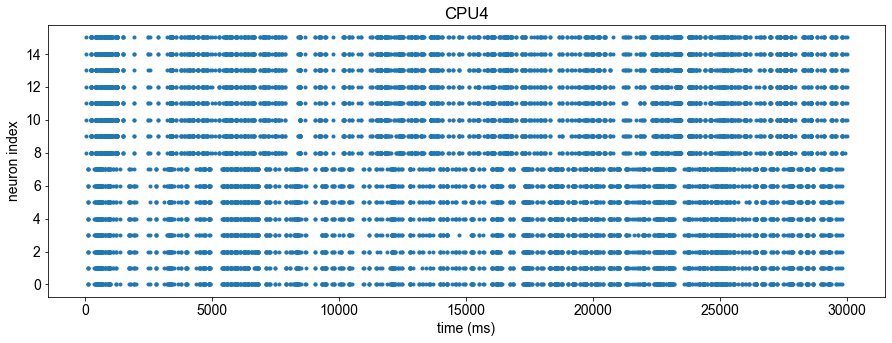

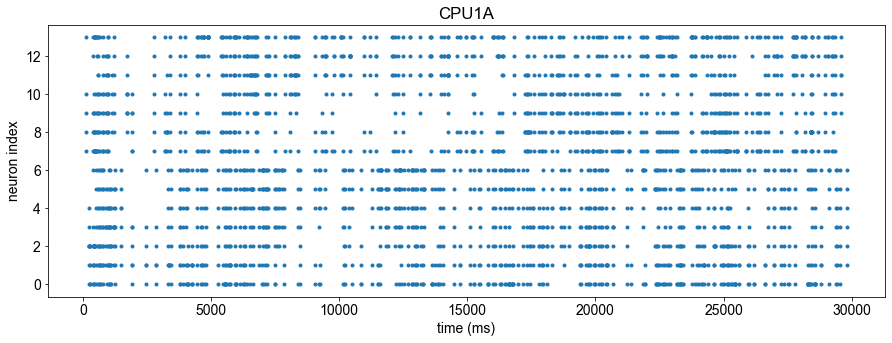

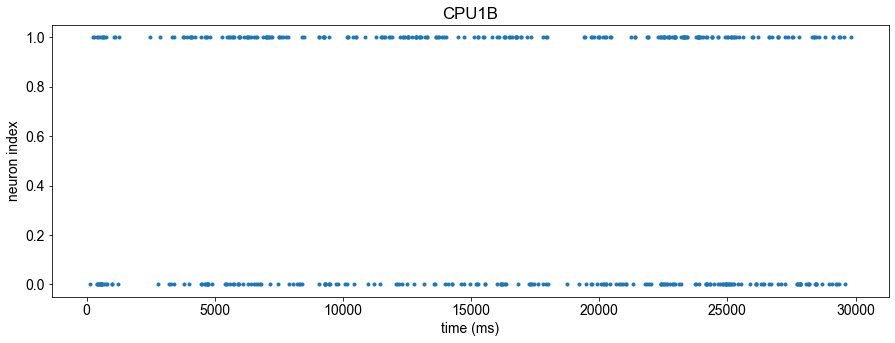

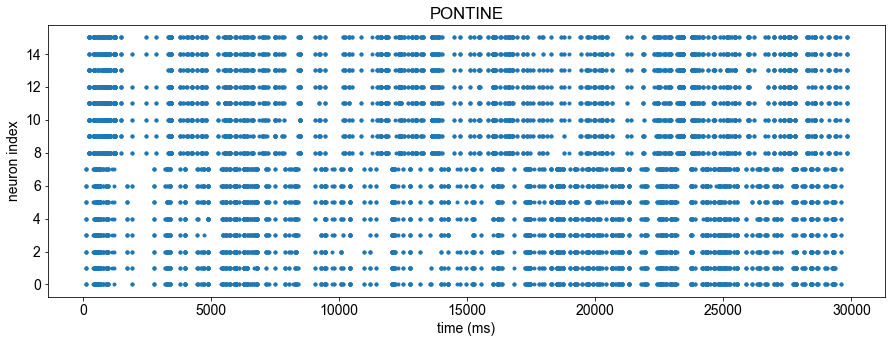

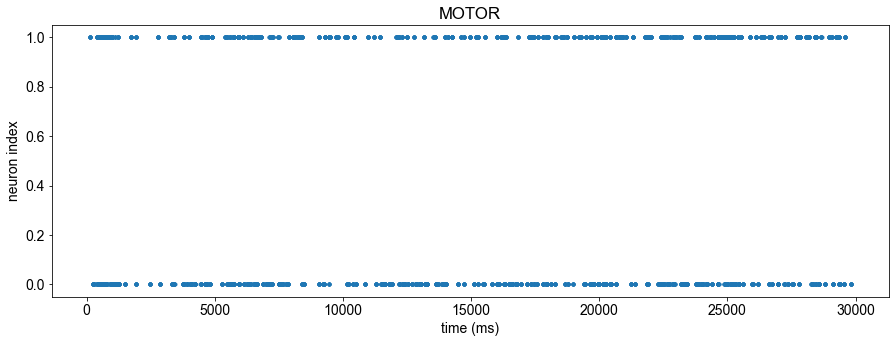

In [15]:
cx_spiking.plotting.plot_raster_plot(SPM_TL2, title='TL2')
cx_spiking.plotting.plot_raster_plot(SPM_CL1, title='CL1')
cx_spiking.plotting.plot_raster_plot(SPM_TB1, title='TB1')
cx_spiking.plotting.plot_raster_plot(SPM_TN2, title='TN2')
cx_spiking.plotting.plot_raster_plot(SPM_CPU4, title='CPU4')
cx_spiking.plotting.plot_raster_plot(SPM_CPU1A, title='CPU1A')
cx_spiking.plotting.plot_raster_plot(SPM_CPU1B, title='CPU1B')
cx_spiking.plotting.plot_raster_plot(SPM_PONTINE, title='PONTINE')
cx_spiking.plotting.plot_raster_plot(SPM_MOTOR, title='MOTOR')

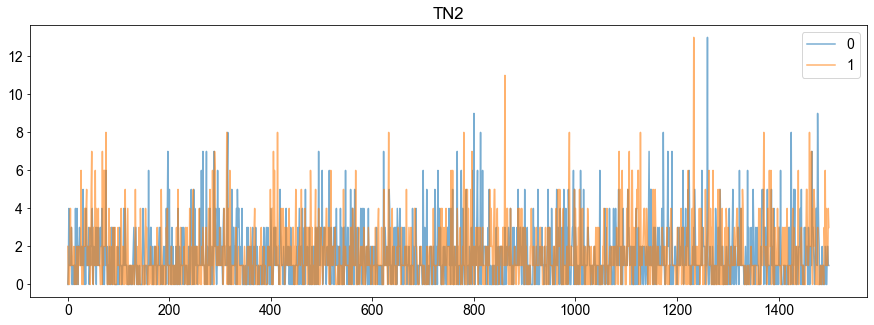

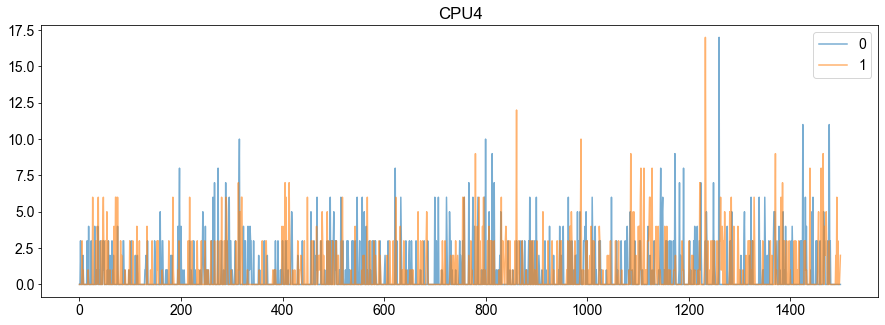

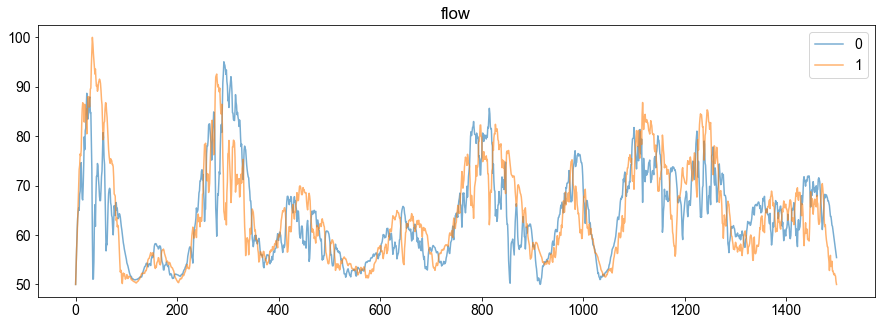

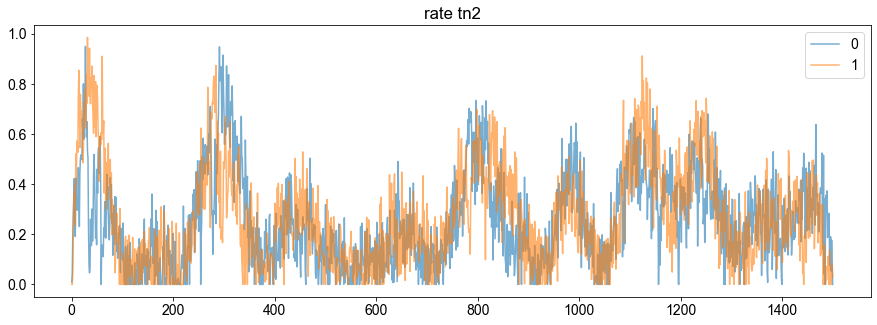

In [44]:
TN2_rates = cx_spiking.inputs.get_spikes_rates(SPM_TN2, N_TN2, T_outbound, time_step)
CPU4_rates = cx_spiking.inputs.get_spikes_rates(SPM_CPU4, N_CPU4, T_outbound, time_step)

plt.figure(figsize=(15,5))
plt.title('TN2')
for idx, r in enumerate(TN2_rates):
    plt.plot(r, alpha=0.6, label=idx)
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.title('CPU4')
for idx, r in enumerate(CPU4_rates[[0,8],:]):
    plt.plot(r, alpha=0.6, label=idx)
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.title('flow')
for idx, r in enumerate(flow.T):
    plt.plot(r, alpha=0.6, label=idx)
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.title('rate tn2')
for idx, r in enumerate(cx_log.tn2):
    plt.plot(r, alpha=0.6, label=idx)
plt.legend()
plt.show()

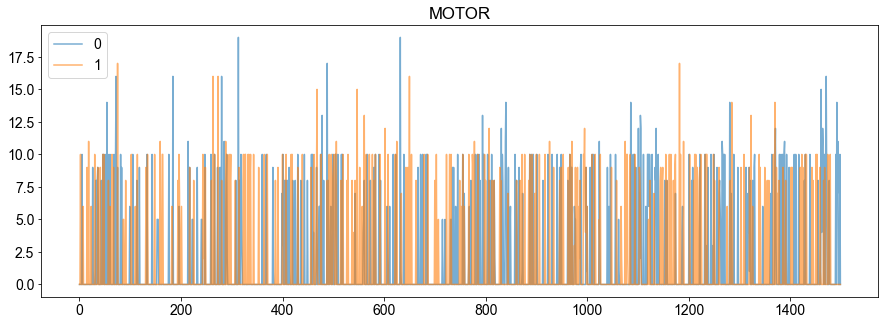

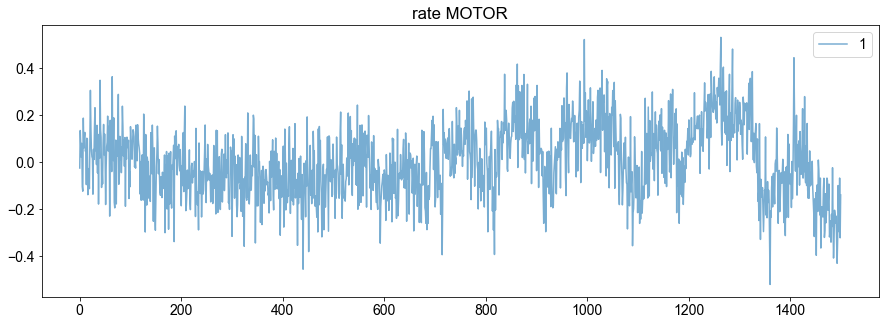

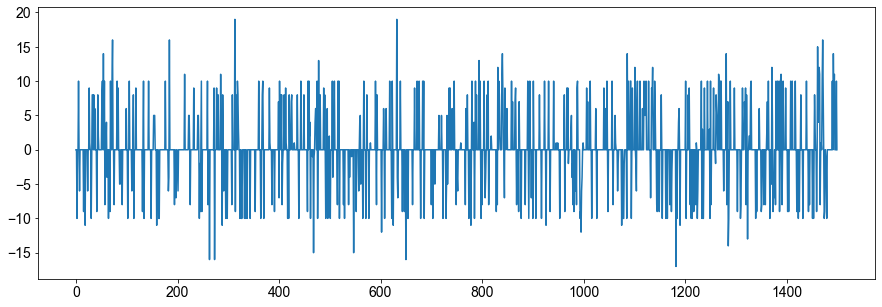

[  0.   0. -10.   0.   0.  10.   0.  -6.   0.   0.   0.   0.   0.   0.
   0.  -9.   0.   0. -11.   0.   0.   0.   0.  -6.   0.   0.   9.   1.
   0.   0. -10.   0.   8.   8.   0.   8.   0.   6.   0.   0.   0.  -9.
   0.   8.   2.   0.   0.   0.   0.   0.   0.   8.  10.   0.  14.   0.
  10.  -8.   0.   0.   4.  -4.   0.   0. -10.   0.   0.  -9.  10.   0.
   0.  10.  16.   0.   0.  -8.   0.   0.   0.   0.   0.  10.   0.   9.
   0.   0.  -5.  -5.   0.   0.   0.  -8.   0.   0.   0.   0.   0.   0.
   0.   6.   0.   0. -10.   0.   0.  10.   0.   0.   0.   0.  -6.   0.
   0.   8. -10.   0.   0.   0.   9.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.  -9.   0.  10. -10.   0.   0.   0.   0.   0.
   0.   0.   0.  10.   0.   0.   0.   0. -10.   0.   0.   0.   0.   5.
   5.   5.   0.   0.   0. -11.   0.   0.   0. -10. -10.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.  10.   0.   0.   0.   0.   0.
  -6.  -4.  16.   0.   0.   0.   0.   0.   0.   0.   0.   0.  -8.   0.
  -4. 

In [53]:
MOTOR_spikes =  cx_spiking.inputs.get_spikes_rates(SPM_MOTOR, N_MOTOR, T_outbound, time_step)

plt.figure(figsize=(15,5))
plt.title('MOTOR')
for idx, r in enumerate(MOTOR_spikes):
    plt.plot(r, alpha=0.6, label=idx)
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.title('rate MOTOR')
plt.plot(cx_log.motor, alpha=0.6, label=idx)
plt.legend()
plt.show()



plt.figure(figsize=(15,5))
plt.plot((MOTOR_spikes[0,:]-MOTOR_spikes[1,:]))
plt.show()

print((MOTOR_spikes[0,:]-MOTOR_spikes[1,:])[:300])

(1500,)


In [22]:
import pickle
all_monitors = [SPM_TL2.get_states(),
                SPM_CL1.get_states(),
                SPM_TB1.get_states(),
                SPM_TN2.get_states(),
                SPM_CPU4.get_states(),
                SPM_CPU1A.get_states(),
                SPM_CPU1B.get_states(),
                SPM_PONTINE.get_states(),
                SPM_MOTOR.get_states()]
with open('fitted_model_04/monitor.pkl', 'wb') as fh:
    pickle.dump(all_monitors, fh)

In [15]:
motors = cx_spiking.inputs.compute_motors(cx_log.cpu1)
print(motors.shape)

(2, 1500)


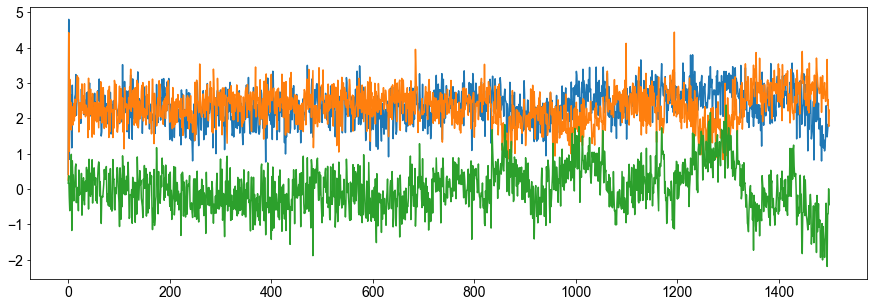

In [16]:
plt.figure(figsize=(15,5))
plt.plot(motors.T)
plt.plot( (motors[0] - motors[1]))
plt.show()

plt.show()

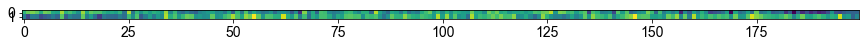

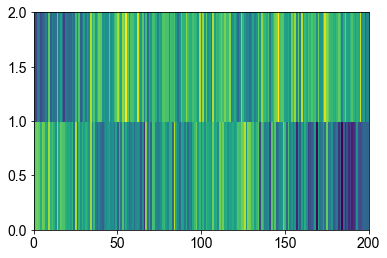

In [29]:
plt.figure(figsize=(15,5))
plt.imshow(motors[:,-200:])
plt.show()

plt.pcolormesh(motors[:,-200:])

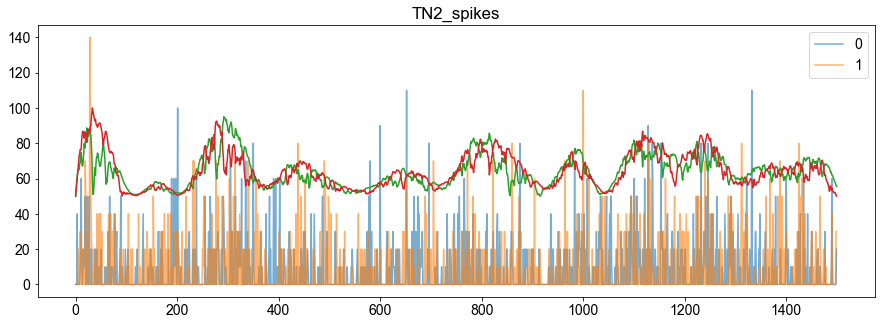

In [35]:
TN2_spikes =  cx_spiking.inputs.get_spikes_rates(SPM_TN2, N_TN2, T_outbound, time_step)

plt.figure(figsize=(15,5))
plt.title('TN2_spikes')
for idx, r in enumerate(TN2_spikes):
    plt.plot(r*10, alpha=0.6, label=idx)
plt.legend()
plt.show()

